## Data Visualization with PCA and TSNE

The following code explores the image set for the Kaggle competition "Plant Seedlings Classification". The data for this repo can be downloaded from https://www.kaggle.com/pavanireddyv/plant-seedling-classification-cnn/data.

In [1]:
# Import Libraries
import os
import cv2
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from random import randint

C:\Users\Richard\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set up paths
train_path = 'train'
test_path = 'test'

In [3]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_categories = len(categories)

In [4]:
for category in categories:
    print('{}: {} images'.format(category, len(os.listdir(os.path.join(train_path, category)))))

Black-grass: 263 images
Charlock: 390 images
Cleavers: 287 images
Common Chickweed: 611 images
Common wheat: 221 images
Fat Hen: 475 images
Loose Silky-bent: 654 images
Maize: 221 images
Scentless Mayweed: 516 images
Shepherds Purse: 231 images
Small-flowered Cranesbill: 496 images
Sugar beet: 385 images


In [5]:
train_list = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(train_path, category)):
        train_list.append([category_id, 'train/{}/{}'.format(category, file), category])
train_df = pd.DataFrame(train_list, columns=['category_id', 'file', 'category'])

In [15]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def visualize_scatter_plot(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')

def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [7]:
def process_images(train_df):
    image_array = []

    for image_path in train_df['file']:
        temp_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        temp_image = cv2.resize(temp_image, (224, 224))
        temp_image = segment_plant(temp_image)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
        temp_image = cv2.resize(temp_image, (45,45))

        temp_image = temp_image.flatten()

        image_array.append(temp_image)

    return image_array

In [8]:
image_array = process_images(train_df)
label_array = np.array(train_df['category'])
np_image_array = np.array(image_array)
scaled_image_array = StandardScaler().fit_transform(np_image_array)


C:\Users\Richard\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(label_array))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in label_array])

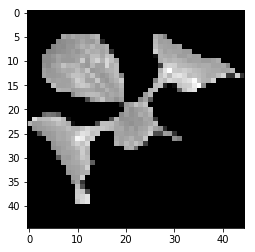

In [10]:
plt.imshow(np.reshape(image_array[400], (45,45)), cmap="gray")

## PCA

Principal Component Analysis provides the first reduction in dimensionality

In [11]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(scaled_image_array)

## TSNE (components = 2)

TSNE provides an additional reduction in dimensionality

In [12]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
scaled_tsne_result =StandardScaler().fit_transform(tsne_result)

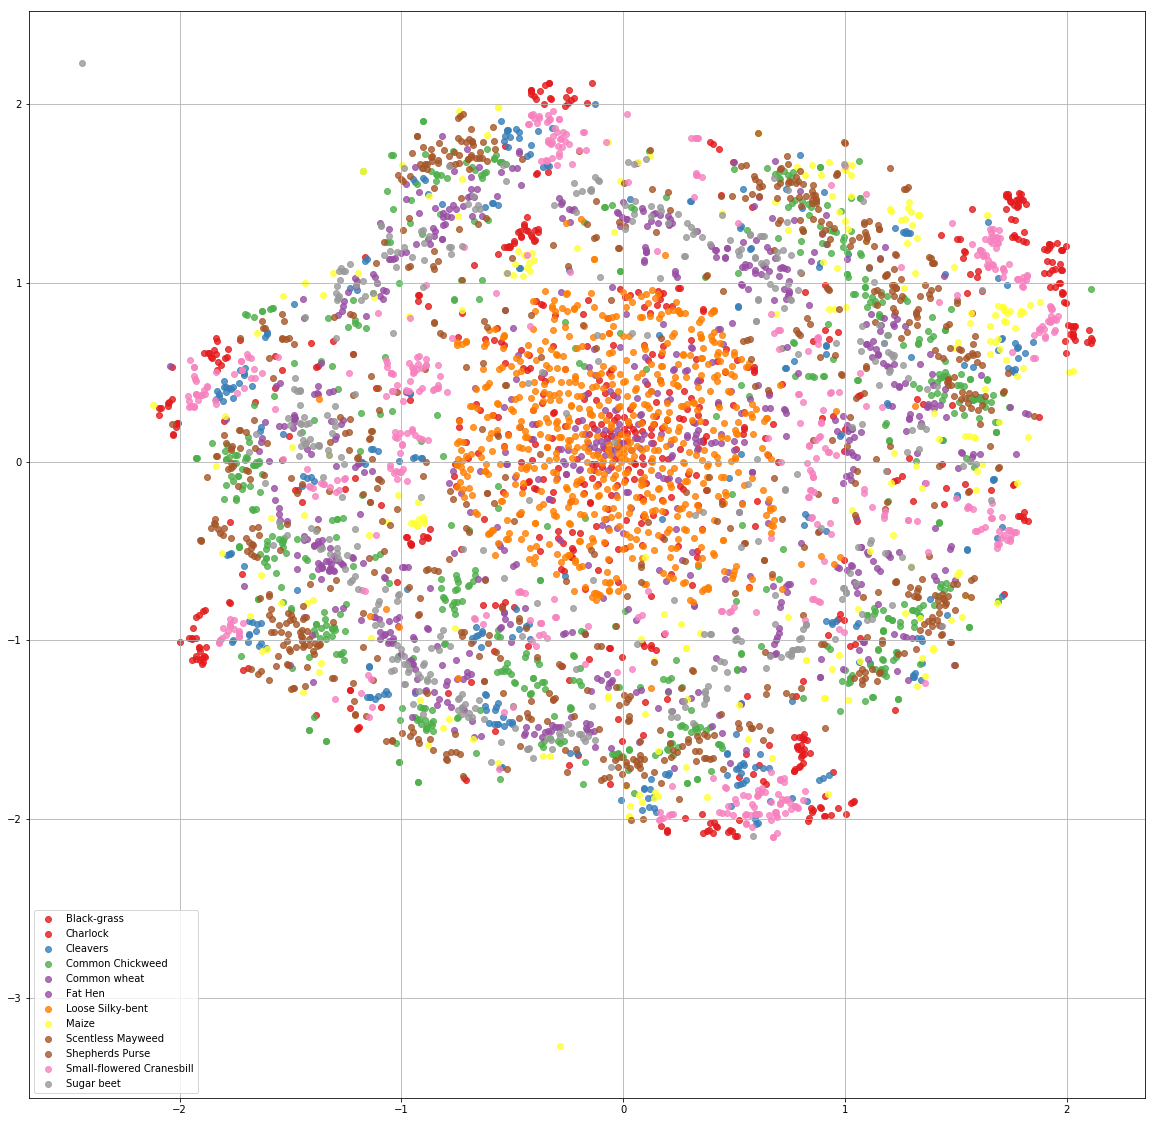

In [16]:
visualize_scatter_plot(scaled_tsne_result, label_ids)